    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None
         

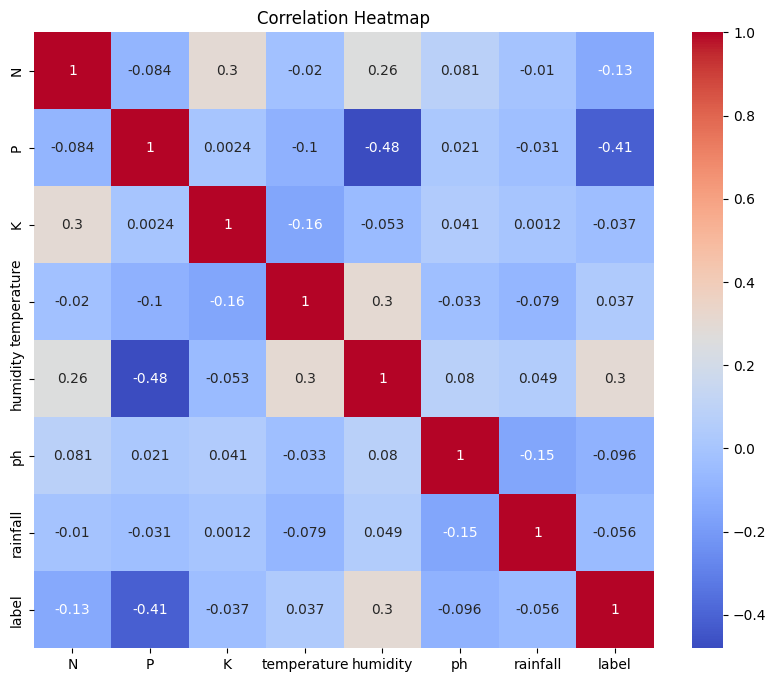

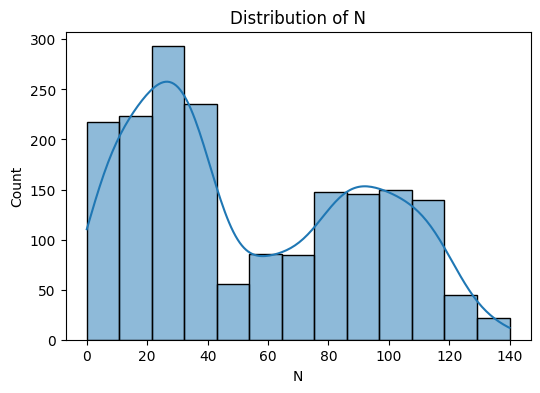

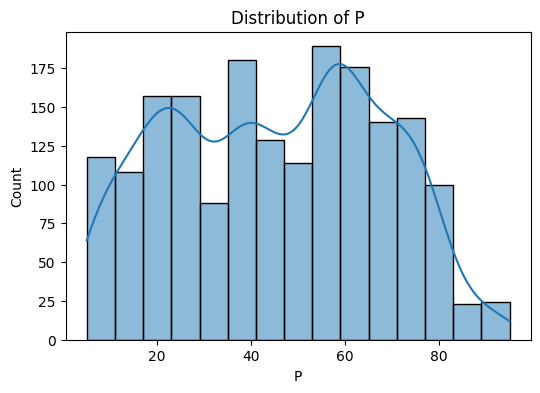

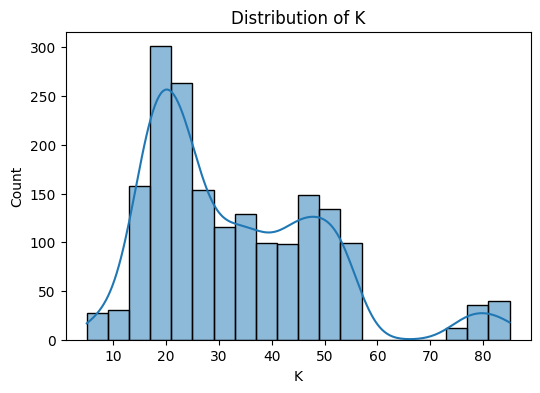

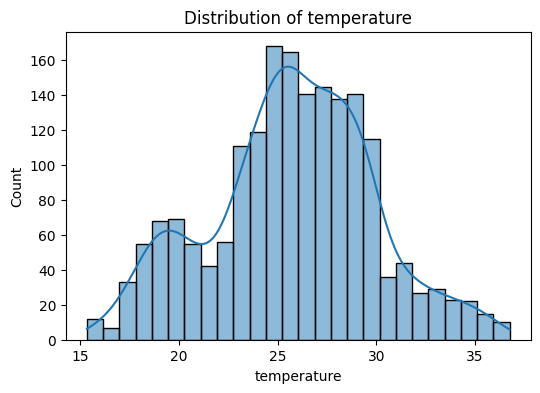

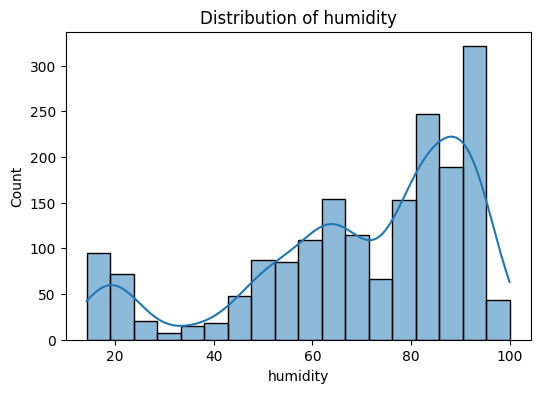

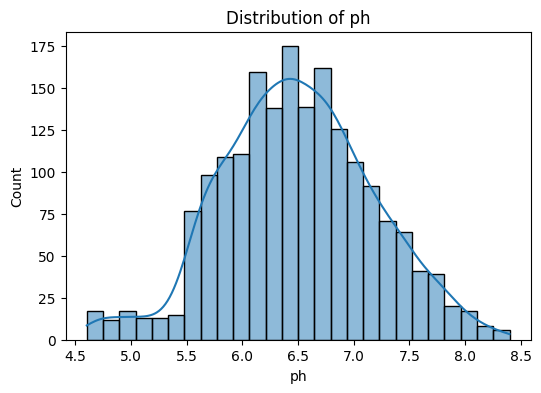

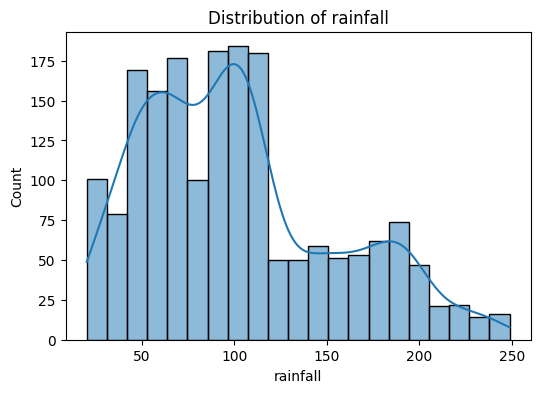

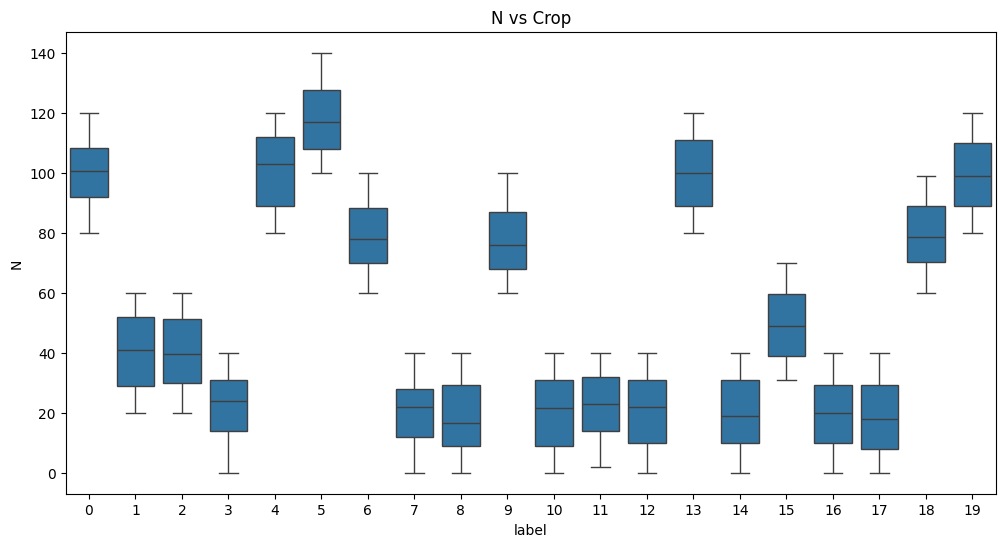

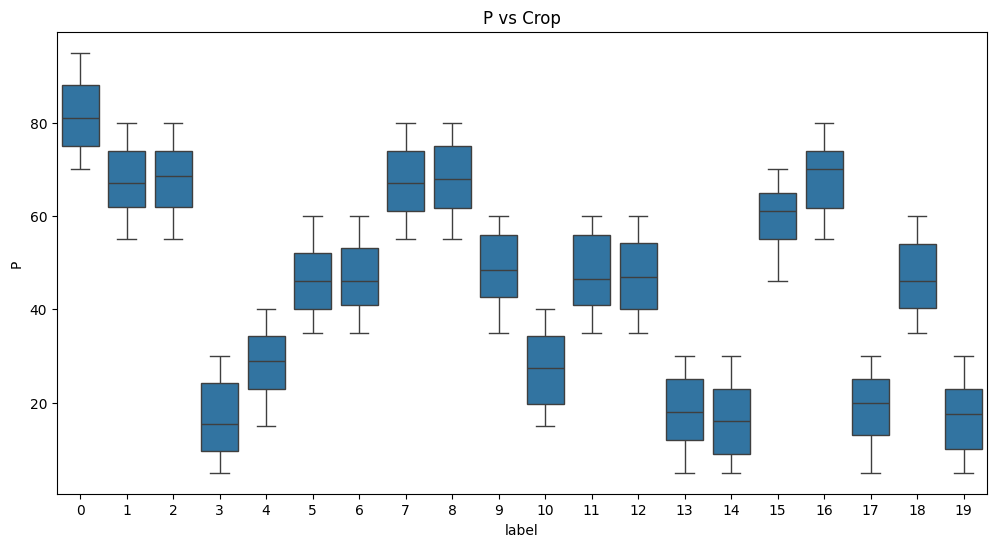

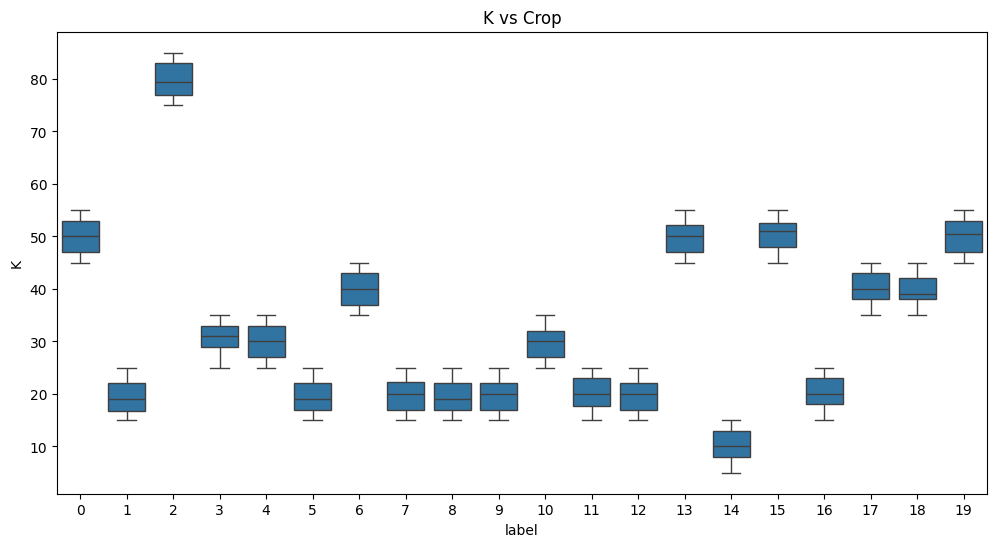

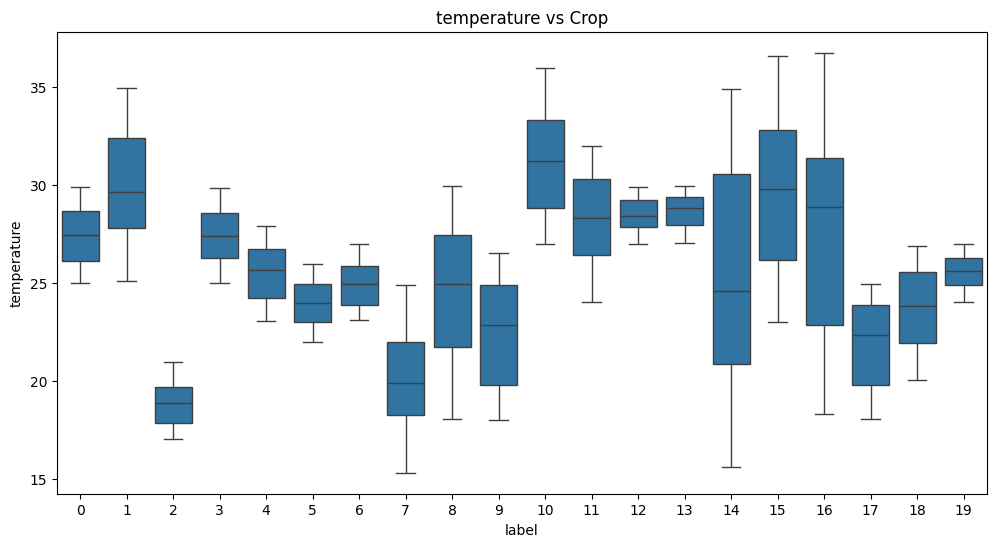

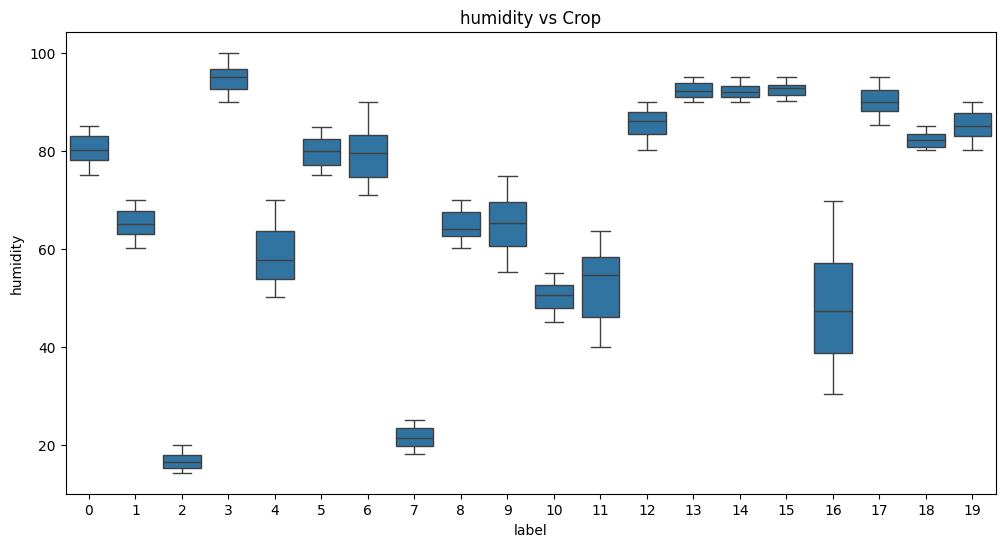

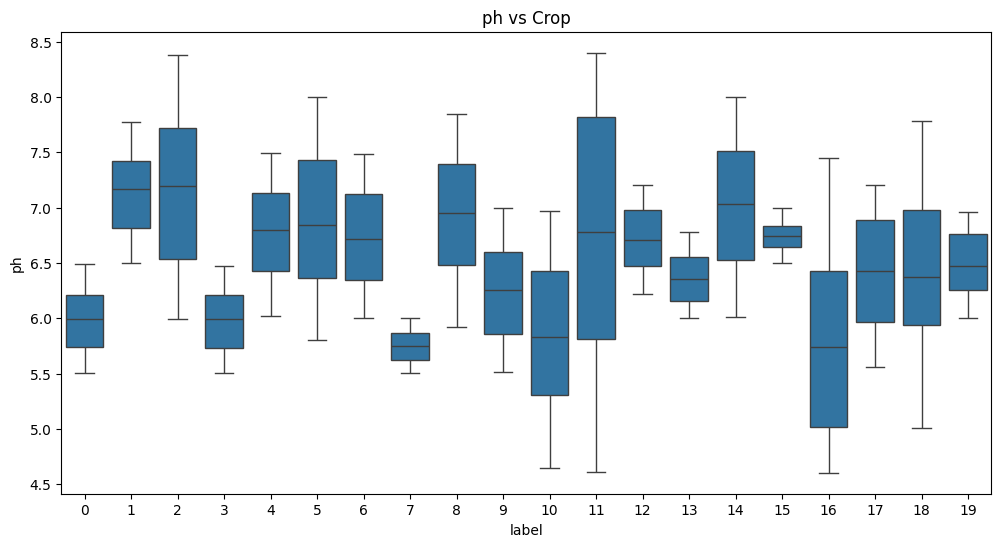

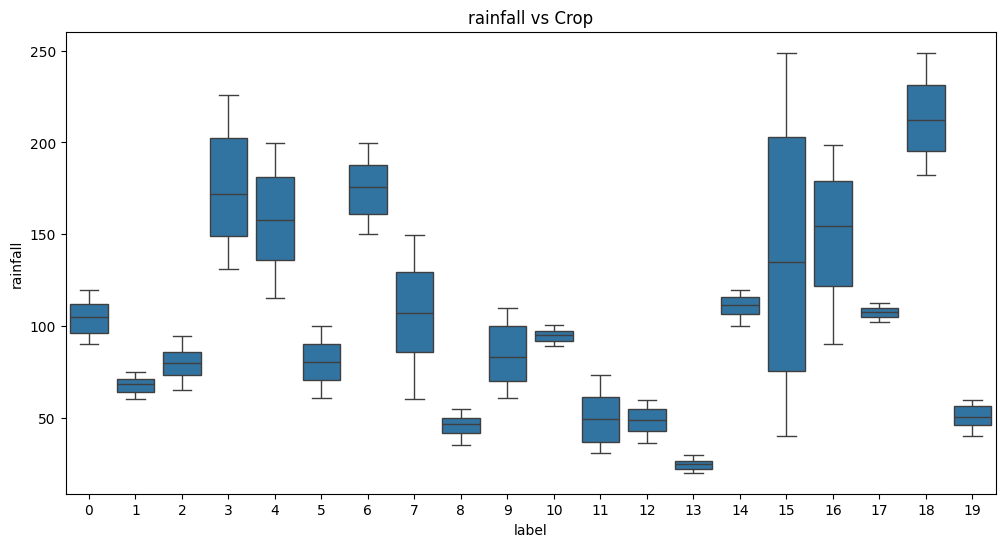


Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.89      1.00      0.94        16
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       0.96      1.00      0.98        27
           5       1.00      1.00      1.00        20
           6       0.82      0.90      0.86        10
           7       0.92      1.00      0.96        23
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        25
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        14
          16       1.00      0.85      0.92        

e:\SRI PROJECT\AgriMitraAI\CropRecommendationSystem\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:36:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        20
           6       0.83      1.00      0.91        10
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        25
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        14
          16       1.00      1.00      1.00        27
         

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import joblib

# Step 1: Load the dataset
df = pd.read_csv('Crop_recommendation.csv')

# Display basic info
print(df.head())
print(df.info())
print(df.describe())
print(df['label'].unique())  # Check unique crops

# Step 2: Preprocess the data
# Handle missing values (if any)
df = df.dropna()

# Handle outliers (using IQR method for each feature)
for col in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

# Encode the target variable (crops)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
joblib.dump(le, 'label_encoder.pkl')  # Save encoder for later use in app

# Step 3: Exploratory Data Analysis (EDA)
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Distribution of features
for col in df.columns[:-1]:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Boxplots for features vs crop
for col in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f'{col} vs Crop')
    plt.show()

# Step 4: Split the dataset
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')  # Save scaler for app

# Step 5: Train multiple models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    
    results[name] = {'Accuracy': acc, 'F1-Score': f1, 'Precision': prec, 'Recall': rec}
    
    print(f'\n{name} Metrics:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

# Display comparison
results_df = pd.DataFrame(results).T
print('\nModel Comparison:')
print(results_df)

# Step 6: Select and fine-tune the best model (Random Forest, assuming it performs best)
best_model = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print('\nBest Parameters:', grid_search.best_params_)

# Evaluate fine-tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print('\nFine-Tuned Random Forest Metrics:')
print(classification_report(y_test, y_pred))

# Step 7: Save the model
joblib.dump(best_model, 'model.pkl')
print('Model saved as model.pkl')

In [13]:
%pip install -r pandas



Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pandas'
